In [12]:
import pandas as pd
from paintone_rsn.data_loading import load_subjectiid, exclusion, load_timeseries
from paintone_rsn.data_preproc import connectivity_matrix, connectivitylabelname
import paintone_rsn.mlfunctions as myml
import pickle

## We work with the output of the RPN-signature (see https://spisakt.github.io/RPN-signature/ for details).
### We called it in the following way:
sudo docker run -it --rm -v .../A_data_mri/:/data:ro -v .../rpnresult/:/out tspisak/rpn-signature:latest /data /out participant --keep_all --keep_derivatives --mem_gb 20 --nthreads 10
### We work with the following outputs:
1. timeseries folder - contains all the participants' time series data from the MIST122 atlas (https://mniopenresearch.org/articles/1-3) (ROIs are columns).
2. motion_summary.csv - the motion summary statistics (mean framewise displacement(FD),	median FD, maximum FD, scrubbed percent (perc_scrubbed))
3. subjectIDs.txt - The mapping between the study subject ID and the ID in the output of the RPN-signature.
4. individual "volume-wise" motion parameters for scrubbing.

# Train the model and save it for further use
- Load the behavior data
- Load timeseries and do the scrubbing in the same step
- Calculate individual connectivity matricies
- Train the model

In [2]:
# load behavior variables for the discovery sample
pathtodiscoversmpl="C:/Users/lenov/PycharmProjects/paintone_rsn/data_in/discovery_smpl/"
discovery_behav = pd.read_pickle("C:/Users/lenov/PycharmProjects/paintone_rsn/data_in/discovery_smpl/discovery_smpl_behav.pkl")
discovery_behav.columns

Index(['meanFD', 'medianFD', 'maxFD', 'perc_scrubbed', 'age', 'anxiety_pain',
       'anxiety_tone', 'diff_anxiety', 'hpt', 'tt', 'y_valpainlearn_acq',
       'y_valtonelearn_acq', 'y_valpainlearn_ext', 'y_valtonelearn_ext',
       'y_paincont_acq', 'y_tonecont_acq', 'y_safetycont_acq',
       'y_paincont_ext', 'y_tonecont_ext', 'y_safetycont_ext',
       'hab_UCS_pain_vas', 'hab_UCS_tone_vas', 'PASS_D1', 'PASS_D2', 'PASS_D3',
       'PASS_D4', 'PCS', 'ADS'],
      dtype='object')

In [29]:

#filename = 'C:/Users/lenov/PycharmProjects/paintone_rsn/data_in/discovery_smpl/discovery_smpl_behav.pkl'
#pickle.dump(discovery_behav, open(filename, 'wb'))
#s0_behav['y_valpainlearn_acq'].equals(valencedata['y_valpainlearn_acq'])

In [5]:
# load included subjects' timeseries
s0_dict_subjID_idx = load_subjectiid('C:/Users/lenov/PycharmProjects/paintone_rsn/data_in/discovery_smpl/subjectsIDs.txt')
s0_subjID_idx_incl, s0_subjID_idx_excl,s0_motioninf_curr = exclusion('C:/Users/lenov/PycharmProjects/paintone_rsn/data_in/discovery_smpl/motion_summary.csv',
                                             dict_subjID_idx=s0_dict_subjID_idx,
                                             excl_subj=[8,18,31])
# Reason of exclusion
# -subj 8 felt asleep in the scanner
# -subj 18 - missing behavior data
# -subj 31 - missing mri data
timeseries_s0,\
labels,\
loadedsubjpath,\
vectorizedlabels,\
listoflabelpairs = load_timeseries('C:/Users/lenov/PycharmProjects/paintone_rsn/data_in/discovery_smpl/timeseries/',
                                   s0_subjID_idx_incl.values(),
                                   fddir=["C:/Users/lenov/Documents/Katistudy/rpnresults/calculate_FD_Power/mapflow/"],
                                   numofexlcvolsatthebeg=0)
#calculate the connectivity matrix based on the timeseries and vectorize them
X, cm = connectivity_matrix(timeseries_s0)

# convert the connectivity matrix to a pandsa dataframe
s0_features_scr = pd.DataFrame(X,
            columns=(vectorizedlabels),
            index = s0_subjID_idx_incl.keys())


These are the subjects subjectID who were excluded:	dict_keys([4, 7, 8, 14, 16, 18, 22, 24, 25, 29, 36, 43, 44])
These are the subjects ordererID who were excluded:	dict_values([1, 3, 4, 7, 9, 11, 15, 17, 18, 21, 26, 33, 34])
These are the subjects subjectID who were included:	dict_keys([3, 5, 9, 12, 15, 17, 19, 20, 21, 23, 27, 28, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 45, 46, 47])
These are the subjects ordererID who were included:	dict_values([0, 2, 5, 6, 8, 10, 12, 13, 14, 16, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 35, 36, 37])
In total we work with	25	 participants.
 Check if all the aprticipanst have behavior data!!!!
Number of participant excluded based in the motion parameters(FD>0.15,scrubbed percent>25):11
this is their subjID 	4	and this is thier orderID:	1
this is their subjID 	7	and this is thier orderID:	3
this is their subjID 	8	and this is thier orderID:	4
this is their subjID 	14	and this is thier orderID:	7
this is their subjID 	16	and this is thier orderID:

**** Non-nested analysis ****
** Best hyperparameters: {'fsel__k': 10, 'model__alpha': 0.001}
** Score on full data as training set:	-16.989490769596067
** Score on mean as model: -543.4399999999999
** Best Non-nested cross-validated score on test:	-237.03589637349822
XXXXX Explained Variance: 0.5638232438291289
**** Nested analysis ****
model	inner_cv mean score	outer vc score
{'fsel__k': 25, 'model__alpha': 0.005} -381.1783053616876 -628.6243229376777
{'fsel__k': 15, 'model__alpha': 0.005} -329.05634081012255 -102.36716308273698
{'fsel__k': 30, 'model__alpha': 0.001} -398.00867623613993 -86.32871671449912
{'fsel__k': 30, 'model__alpha': 0.001} -309.2616407895084 -527.8255951586028
{'fsel__k': 15, 'model__alpha': 0.001} -255.30721619082132 -18.75353708014942
{'fsel__k': 45, 'model__alpha': 0.001} -454.9948917771312 -224.8032101852697
{'fsel__k': 10, 'model__alpha': 0.001} -240.1957213814061 -150.81217413927052
{'fsel__k': 20, 'model__alpha': 0.001} -379.67507583902426 -0.4215246849243

c:\users\lenov\pycharmprojects\fear_conditiong_and_rsns\venv\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\lenov\pycharmprojects\fear_conditiong_and_rsns\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


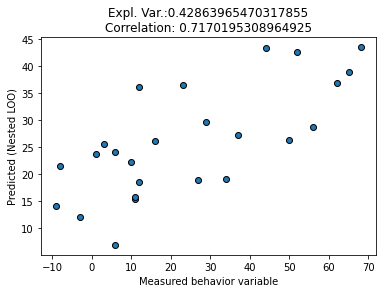

R2=0.640  R=0.800   p=0.000002  Expl. Var.: 56.4%  Expl. Var.2: 56.5%  MSE=237.036 RMSE=15.396  MAE=11.410 MedAE=9.724  R^2=0.564


c:\users\lenov\pycharmprojects\fear_conditiong_and_rsns\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


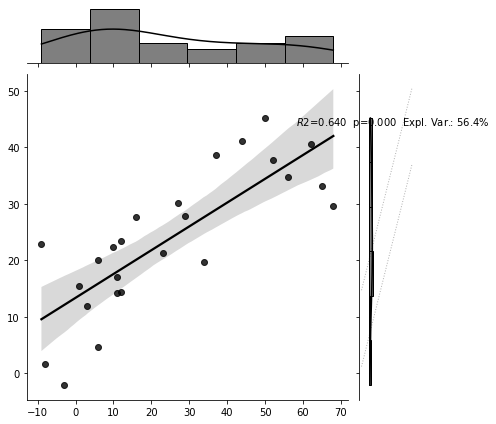

In [6]:
y_reg = discovery_behav['y_valpainlearn_acq'].to_numpy()
X_reg = s0_features_scr.to_numpy() #s0_features
mymodel, p_grid = myml.pipe_scale_fsel_ridge_noscaler()
m_scr, m_scr_predictedval, m0_scr_all_models, m0_scr_mycrossval, m0_scr_myfig, m0_scr_explvar, m0_scr_predicted = \
    myml.mytrain(X_reg,
                        y_reg,
                        mymodel,
                        p_grid, nested=True)
myprediction = myml.evaluate_crossval_prediction(m_scr,X_reg, y_reg,outfile=[])

In [7]:
# saving the model for further use
#filename = 'C:/Users/lenov/PycharmProjects/paintone_rsn/data_out/final_model_M1.sav'
#pickle.dump(m_scr, open(filename, 'wb'))

In [16]:
# show the connections in table format
connectivitylabelname(m_scr,listoflabelpairs)


the total number of predictive connections:10
['POsul_v', 'SPlob.1']
['L_IPlob.1', 'IMsul']


,conn,strenght,region1,roival_region1,mainparent_region1,mainparentname_region1,region2,roival_region2,mainparent_region2,mainparentname_region2
1,"[L_DVIS_v, R_PORB]",-92.657756,left_DORSAL_VISUAL_STREAM_ventral,50.0,6.0,FRONTO_PARIETAL_NETWORK_and_VISUAL_DOWNSTREAM,right_PARS_ORBITALIS,92.0,6.0,FRONTO_PARIETAL_NETWORK_and_VISUAL_DOWNSTREAM
4,"[PINS_v, L_MOTnet_dl]",84.359578,POSTERIOR_INSULA_ventral,21.0,2.0,MESOLIMBIC_NETWORK,left_SOMATOMOTOR_NETWORK_dorsolateral,8.0,3.0,SOMATOMOTOR_NETWORK
8,"[CER5, MVISnet_ad]",-80.804677,CEREBELLUM_I-V,48.0,1.0,CEREBELLUM,MEDIAL_VISUAL_NETWORK_anterodorsal,19.0,4.0,VISUAL_NETWORK
3,"[DVIS_vl, AMY]",-79.285258,DORSAL_VISUAL_STREAM_ventrolateral,100.0,6.0,FRONTO_PARIETAL_NETWORK_and_VISUAL_DOWNSTREAM,AMYGDALA,71.0,2.0,MESOLIMBIC_NETWORK
7,"[PUT_p, PVISnet_dm]",-49.246654,PUTAMEN_posterior,25.0,7.0,VENTRAL_ATTENTION_NETWORK_and_SALIENCE_NETWORK...,POSTERIOR_VISUAL_NETWORK_dorsomedial,16.0,4.0,VISUAL_NETWORK
5,"[L_IPlob.1, IMsul]",48.375171,left_INFERIOR_PARIETAL_LOBULE,114.0,5.0,DEFAULT_MODE_NETWORK,INFERIOR_MARGINAL_SULCUS,118.0,7.0,VENTRAL_ATTENTION_NETWORK_and_SALIENCE_NETWORK...
2,"[CER7b_m, COLsul]",43.246548,CEREBELLUM_VIIb_medial,18.0,1.0,CEREBELLUM,COLLATERAL_SULCUS,79.0,2.0,MESOLIMBIC_NETWORK
0,"[POsul_v, SPlob.1]",38.644228,PARIETO_OCCIPITAL_SULCUS_ventral,72.0,5.0,[DEFAULT_MODE_NETWORK],SUPERIOR_PARIETAL_LOBULE,76.0,6.0,[FRONTO_PARIETAL_NETWORK_and_VISUAL_DOWNSTREAM]
9,"[AINS_ad, LVISnet_DP]",-30.534563,ANTERIOR_INSULA_anteroodorsal,85.0,7.0,VENTRAL_ATTENTION_NETWORK_and_SALIENCE_NETWORK...,LATERAL_VISUAL_NETWORK_dorsoposterior,43.0,4.0,VISUAL_NETWORK
6,"[DMPFC_ar, STgyr_m]",6.769029,DORSOMEDIAL_PREFRONTAL_CORTEX_anterororstral,87.0,5.0,DEFAULT_MODE_NETWORK,SUPERIOR_TEMPORAL_GYRUS_middle,88.0,7.0,VENTRAL_ATTENTION_NETWORK_and_SALIENCE_NETWORK...
